Import libraries

In [23]:
#general libraries
import re
import os
import time

#data manipulation libraries
import pandas as pd
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#transformers libraries
from transformers import AutoTokenizer

#metrics libraries
from rouge_score import rouge_scorer
from bert_score import BERTScorer

#pdf libraries
from fpdf import FPDF

#paralelization libraries
from joblib import Parallel, delayed

#for logging purposes
import logging

Load the data

In [24]:
def load_data(dataset_path):
    dataset = pd.read_csv(dataset_path)
    
    # Drop rows with NaN values in critical columns
    dataset = dataset.dropna()

    if dataset.shape[0] > 10000:
        dataset = dataset.sample(10000)
    return dataset

Calculate the similarity to ensure the summaries represent the judgements

In [25]:
def compute_similarity(dataset, judgement_col, summary_col, subset_size=20):

    dataset = dataset.copy()
    
    # Remove any remaining NaN values
    dataset = dataset.dropna(subset=[judgement_col, summary_col])

    # Initialize vectorizer
    vectorizer = TfidfVectorizer()

    # Combine judgements and summaries for consistent vectorization
    combined_texts = pd.concat([dataset[judgement_col], dataset[summary_col]])
    tfidf_matrix = vectorizer.fit_transform(combined_texts)

    # Split back into judgements and summaries
    n_judgements = len(dataset[judgement_col])
    judgements_tfidf = tfidf_matrix[:n_judgements]
    summaries_tfidf = tfidf_matrix[n_judgements:]

    # Compute cosine similarity
    similarity_scores = cosine_similarity(judgements_tfidf, summaries_tfidf)
    diagonal_similarity_scores = np.diagonal(similarity_scores)
    dataset.loc[:, "Similarity Score"] = diagonal_similarity_scores

    subset_judgements = judgements_tfidf[:subset_size]
    subset_summaries = summaries_tfidf[:subset_size]
    subset_similarity_matrix = cosine_similarity(subset_judgements, subset_summaries)

    plt.figure(figsize=(10, 6))
    sns.heatmap(subset_similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Cosine Similarity Heatmap (Judgements vs. Summaries)")
    plt.xlabel("Summaries")
    plt.ylabel("Judgements")
    plt.show()

Calculate the lenght of the judgements and summaries and remove the outliers

In [26]:
def count_tokens(texts, tokenizer):
    return [len(tokenizer(text, truncation=False, padding=False)["input_ids"]) for text in texts]

In [27]:
def analyze_token_distribution(dataset, judgement_col, summary_col, tokenizer_model="t5-small"):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

    dataset = dataset.copy()

    dataset.loc[:, "Judgement_Tokens"] = count_tokens(dataset[judgement_col], tokenizer)
    dataset.loc[:, "Summary_Tokens"] = count_tokens(dataset[summary_col], tokenizer)

    # Print statistics
    print("=" * 60)
    print("TOKEN DISTRIBUTION ANALYSIS")
    print("=" * 60)
    print(f"\nJudgement Tokens Statistics:")
    print(f"  Count: {dataset['Judgement_Tokens'].count()}")
    print(f"  Mean: {dataset['Judgement_Tokens'].mean():.2f}")
    print(f"  Median: {dataset['Judgement_Tokens'].median():.2f}")
    print(f"  Std Dev: {dataset['Judgement_Tokens'].std():.2f}")
    print(f"  Min: {dataset['Judgement_Tokens'].min()}")
    print(f"  Max: {dataset['Judgement_Tokens'].max()}")
    print(f"  Quartiles - 25%: {dataset['Judgement_Tokens'].quantile(0.25):.2f}, 50%: {dataset['Judgement_Tokens'].quantile(0.50):.2f}, 75%: {dataset['Judgement_Tokens'].quantile(0.75):.2f}")

    print(f"\nSummary Tokens Statistics:")
    print(f"  Count: {dataset['Summary_Tokens'].count()}")
    print(f"  Mean: {dataset['Summary_Tokens'].mean():.2f}")
    print(f"  Median: {dataset['Summary_Tokens'].median():.2f}")
    print(f"  Std Dev: {dataset['Summary_Tokens'].std():.2f}")
    print(f"  Min: {dataset['Summary_Tokens'].min()}")
    print(f"  Max: {dataset['Summary_Tokens'].max()}")
    print(f"  Quartiles - 25%: {dataset['Summary_Tokens'].quantile(0.25):.2f}, 50%: {dataset['Summary_Tokens'].quantile(0.50):.2f}, 75%: {dataset['Summary_Tokens'].quantile(0.75):.2f}")
    print("=" * 60)

    # Create boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot([dataset['Judgement_Tokens'], dataset['Summary_Tokens']], 
                labels=['Judgement Tokens', 'Summary Tokens'],
                patch_artist=True)
    plt.ylabel('Number of Tokens')
    plt.title('Token Distribution Boxplot')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return dataset

In [ ]:
def pipeline():
    # TODO: change the dataset if needed (legal, legal_cleaned)
    dataset_path = 'datasets/legal_cleaned.csv'

    dataset = load_data(dataset_path)

    compute_similarity(
        dataset=dataset, 
        judgement_col="judgement", 
        summary_col="summary", 
        subset_size=20, 
    )

    dataset_with_tokens = analyze_token_distribution(
        dataset=dataset,
        judgement_col="judgement",
        summary_col="summary",
        tokenizer_model="t5-small"
    )

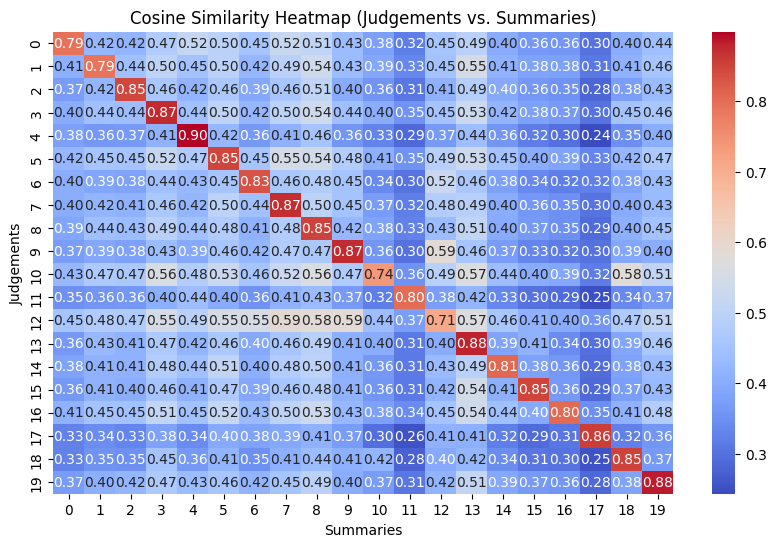

Token indices sequence length is longer than the specified maximum sequence length for this model (12332 > 512). Running this sequence through the model will result in indexing errors


TOKEN DISTRIBUTION ANALYSIS

Judgement Tokens Statistics:
  Count: 6794
  Mean: 4670.86
  Median: 3977.50
  Std Dev: 2786.30
  Min: 267
  Max: 15469
  Quartiles - 25%: 2612.25, 50%: 3977.50, 75%: 6069.00

Summary Tokens Statistics:
  Count: 6794
  Mean: 926.24
  Median: 838.00
  Std Dev: 474.53
  Min: 44
  Max: 2756
  Quartiles - 25%: 563.00, 50%: 838.00, 75%: 1206.75


/var/folders/cv/p0nqqmd92rx65tz16gpm1svw0000gn/T/ipykernel_58307/2480944089.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dataset['Judgement_Tokens'], dataset['Summary_Tokens']],


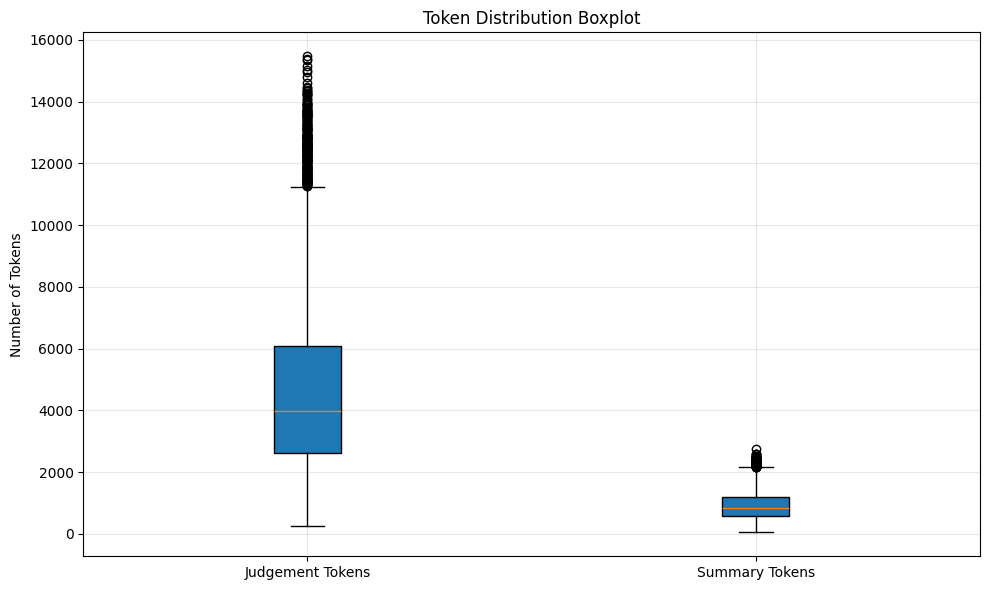

In [29]:
pipeline()